In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt #Библиотеки для визуализации данных
import seaborn as sns
%matplotlib inline
from datetime import datetime

from sklearn.feature_selection import f_classif, mutual_info_classif 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
 precision_recall_curve, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
#DATA_DIR = '/kaggle/input/sf-scoring/'
#df_train = pd.read_csv(DATA_DIR +'/train.csv')
#df_test = pd.read_csv(DATA_DIR +'/test.csv')
#sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
DATA_DIR = '/kaggle/input/sf-scoring/'
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
sample_submission.shape

(36349, 2)

In [7]:
df_test.shape

(36349, 18)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [9]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [11]:
sample_submission.head(5)

,client_id,default
0,74835,0
1,17527,0
2,75683,0
3,26883,0
4,28862,0


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  36349 non-null  int64
 1   default    36349 non-null  int64
dtypes: int64(2)
memory usage: 568.1 KB


In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [14]:
data.nunique(dropna=False)

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

# Предобработка данных

Посмотрим на распределение нашей целевой переменной

In [15]:
not_default = df_train['default'].value_counts()[0]
ratio = not_default/(len(df_train)-not_default)
print(f"Соотношение классов: {ratio:.1f} \nПроцент недефолтных клиентов: {100 * not_default/len(df_train):.1f}")

Соотношение классов: 6.9 
Процент недефолтных клиентов: 87.3


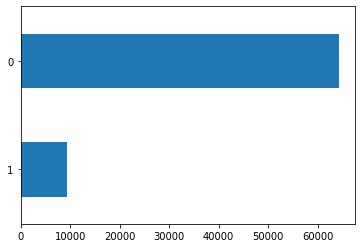

In [16]:
df_train['default'].value_counts(ascending=True).plot(kind='barh')
#Здесь мы можем наблюдать, что выборка не сбалансирована: недефеолтных клиентов больше почти в 7 раз
#Можно сказать, что нам будет труднее искать "плохих" клиентов

Посмотрим на остальные данные 

Работа с пропусками

In [17]:
data.isna().sum()
#Пропуски есть только в образовании

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

In [18]:
data['education'].fillna(data['education'].mode()[0], inplace = True) 

Добавим некоторые функции

In [19]:
def borders(col):
  """ Определяет квантили по признаку col """

  q1 = col.quantile(.25)
  q3 = col.quantile(.75)
  iqr = q3 - q1
  low = q1 - 1.5 * iqr
  high = q3 + 1.5 * iqr
  return low, high

In [20]:
def check_outliers(col, data):
    """Определяет наличие выбросов в признаке col датасета data методом интерквантильного размаха"""
    
    low, high = borders(data[col])
    outliers = ((data[col] < low) | (data[col] > high)).sum()
    
    if not outliers:
        print(f"В признаке '{col}' выбросов нет\n")
        return

    print(f"Количество выбросов в признаке '{col}': {outliers}")
    print(f"Границы выбросов: [{low}, {high}]\n")

## Работа с переменными

### 1. Числовые признаки



*   client_id - идентификатор
*   age - возраст
*   decline_app_cnt - количество отклонённых заявок
*   score_bki - скоринговый балл
*   bki_request_cnt - количество запросов в БКИ
*   region_rating - рейтинг региона
*   income - доход 

In [21]:
data['client_id'].nunique()

110148

In [22]:
#'client_id' не несёт полезной информации для будущей модели
data.drop(['client_id'], axis = 1, inplace=True)

Оставляем следующие признаки

In [23]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'region_rating', 'bki_request_cnt', 'income']

Посмотрим на них

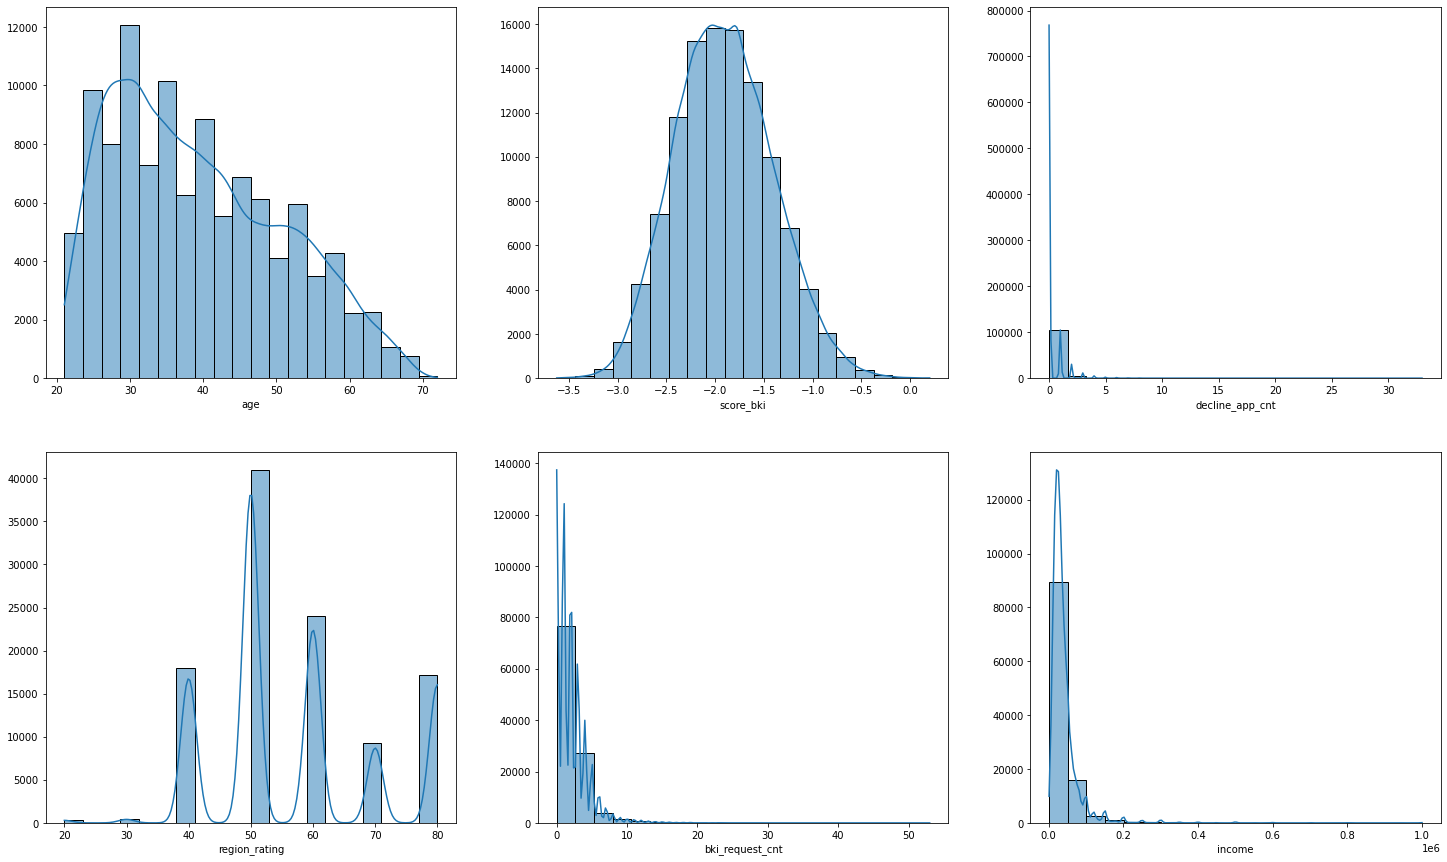

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(25,15))

for i, col in enumerate(num_cols):
    hist = sns.histplot(data[col], bins=20, kde=True, ax=axes.flat[i])
    hist.set(ylabel="")

Возраст - наблюдается смещение в лево. Требуется нормализация

Скоринговый балл - видно нормальное распределение, нормализовать не стоит

У рейтинга регионов тоже, в принципе, идет нормальное распределение

У остальных пирзнаков имеется явное смещение, с ними нужно разбираться 


In [25]:
data.age = data.age.apply(lambda x: np.log(x+1))

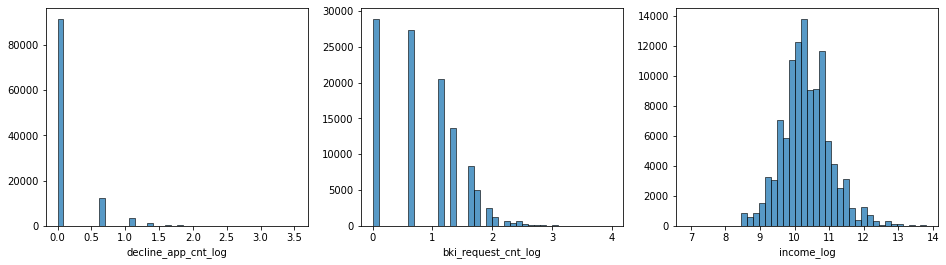

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, col in enumerate(["decline_app_cnt", "bki_request_cnt", "income"]):
    num_cols.append(f"{col}_log")
    data[f"{col}_log"] = np.log(data[col] + 1)
    hist = sns.histplot(data[f"{col}_log"], bins=40, ax=axes.flat[i], kde=False)
    hist.set(ylabel="")



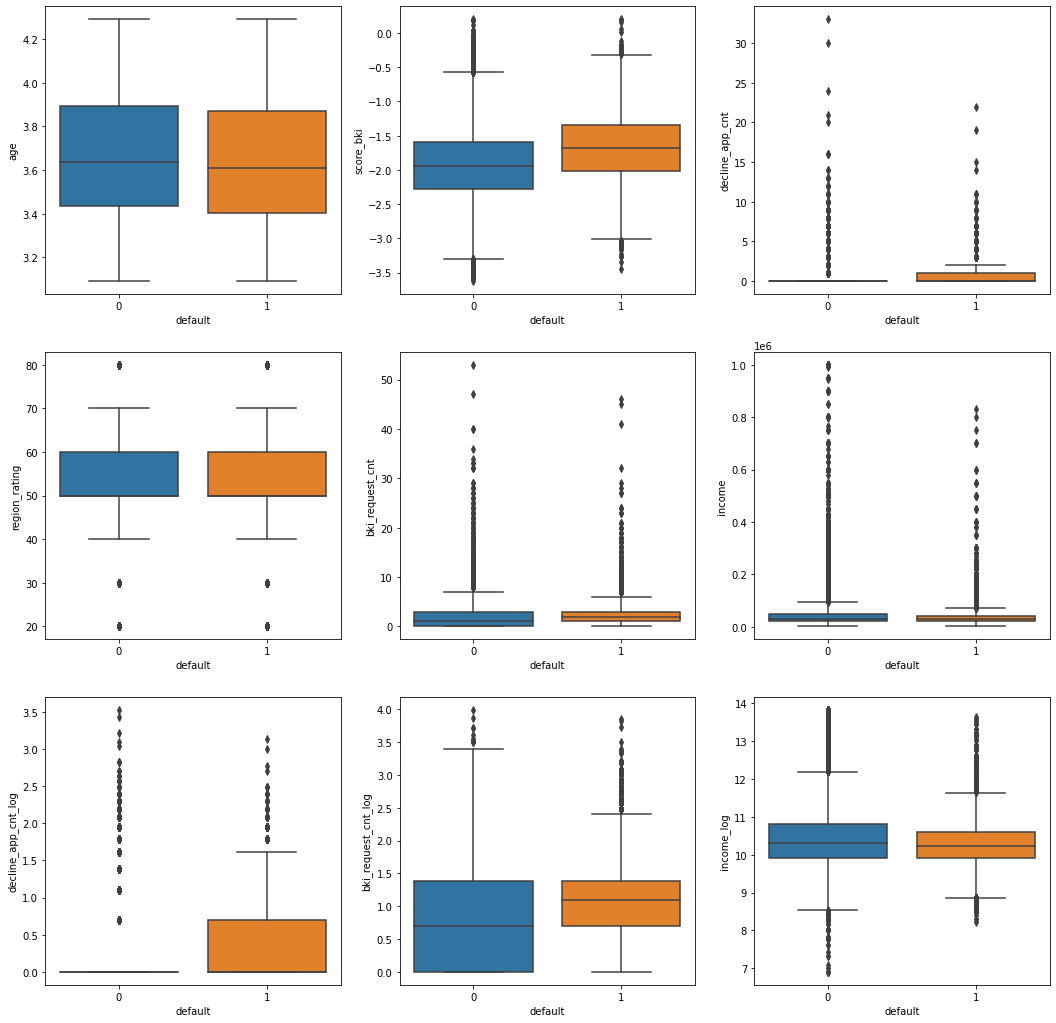

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()
for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=data[data["default"]>=0], orient="v", ax=axes[i])
# видим, например, что у "хороших" клиентов в прошлом обычно не было отказов на выдачу кредитов
# также у них более низкий скоринговый балл и меньше запросов в БКИ

### Работа с выбросами

Построив box-plot'ы можно заметить, что многие данные похожи на выбросы. Надо понять действительно ли это выбросы

In [28]:
for col in num_cols:
    check_outliers(col, data)

В признаке 'age' выбросов нет

Количество выбросов в признаке 'score_bki': 518
Границы выбросов: [-3.299251946250001, -0.5290698762499992]

Количество выбросов в признаке 'decline_app_cnt': 18677
Границы выбросов: [0.0, 0.0]

Количество выбросов в признаке 'region_rating': 17917
Границы выбросов: [35.0, 75.0]

Количество выбросов в признаке 'bki_request_cnt': 2636
Границы выбросов: [-4.5, 7.5]

Количество выбросов в признаке 'income': 7000
Границы выбросов: [-22000.0, 90000.0]

Количество выбросов в признаке 'decline_app_cnt_log': 18677
Границы выбросов: [0.0, 0.0]

Количество выбросов в признаке 'bki_request_cnt_log': 15
Границы выбросов: [-2.0794415416798357, 3.465735902799726]

Количество выбросов в признаке 'income_log': 2609
Границы выбросов: [8.590378193705899, 12.092136480586621]



### **decline_app_cnt**

In [29]:
dac = data["decline_app_cnt"]
dac.mean(), dac.max()

(0.2732051421723499, 33)

Разница между максимальным и средним значением больше чем в 100 раз



---



In [30]:
borders(dac)

(0.0, 0.0)

In [31]:
dac.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
21        1
30        1
20        1
19        1
22        1
33        1
15        1
24        1
Name: decline_app_cnt, dtype: int64

Стандартный подход говорит нам, что в этом признаке всё, кроме нулей - выбросы. Если мы заменим всё на нули, то признак потеряет какую-либо ценность для модели. Потому подойдём к выбросам умнее, сделав из этого признака бинарный (у нас также останется логарифмированный вариант признака): 0 - не было отказов, 1 - были.

In [32]:
dac[dac >= 1] = 1
num_cols.remove("decline_app_cnt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
data["decline_app_cnt"].value_counts()
# заметим, что мы изменили исходные данные (как и хотели)

0    91471
1    18677
Name: decline_app_cnt, dtype: int64

income - действительно не нужный признак, его значимость повышается за счет нормализации, поэтому потом он скорее всего будет удален

### 2. Бинарные признаки

*    sex - пол клиента
*    car - флаг наличия машины
*    car_type - флаг машины-иномарки
*    good_work - флаг наличия "хорошей" работы
*    foreign_passport - флаг наличия иностранного паспорта


In [34]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# целевая переменная "default" и изменённая "decline_app_cnt" также являются бинарными

In [35]:
for i in bin_cols:
  display(data[i].value_counts())

F    61836
M    48312
Name: sex, dtype: int64

N    74290
Y    35858
Name: car, dtype: int64

N    89140
Y    21008
Name: car_type, dtype: int64

0    91917
1    18231
Name: good_work, dtype: int64

N    93721
Y    16427
Name: foreign_passport, dtype: int64

In [36]:
enc = LabelEncoder()
for column in bin_cols:
    data[column] = enc.fit_transform(data[column])

### 3. Категориальные признаки


 *   education - уровень образования
 *   home_address - категория домашнего адреса
 *   work_address - категория рабочего адреса
 *   sna - связь заемщика с клиентами банка
 *   first_time - давность наличия информации о клиенте

In [37]:
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address']

In [38]:
data[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   education     110148 non-null  object
 1   first_time    110148 non-null  int64 
 2   sna           110148 non-null  int64 
 3   work_address  110148 non-null  int64 
 4   home_address  110148 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 4.2+ MB


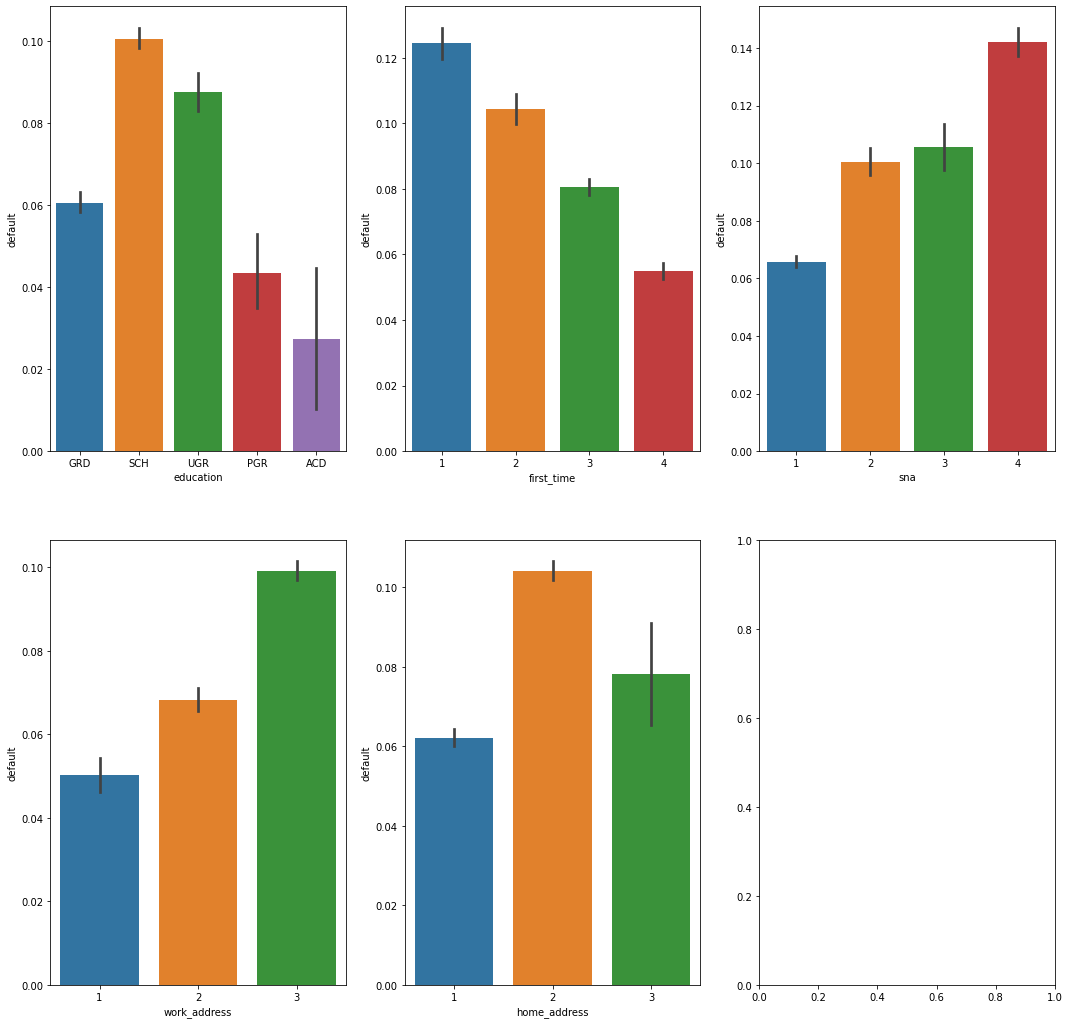

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(18, 18))
axes = axes.flatten()
for i in range(len(cat_cols)):
    sns.barplot(x=cat_cols[i], y="default", data=data[data["default"]>=0], orient="v", ax=axes[i])

Смотря на эти графики можно сделать ледующие выводы:

1. Более образованные - считаются более надежными заемщиками
2. Чем старше сведения о заемщике, тем он более надежен
3. Чем ближе связь заемщика с другими клиентами банка, тем он более надежен

В целом, стоит попробовать закодировать все категориальные переменные с помощью LabelEncoder, а уже после разделения данных дпоплнительно закодировать с помощтю OneHotEncoder


In [40]:
data['education'] = enc.fit_transform(data['education'])

In [41]:
 
columns = cat_cols

for column in columns:
    data[column] = enc.fit_transform(data[column])

In [42]:
data["app_date"] = data["app_date"].apply(lambda x: datetime.strptime(x, '%d%b%Y').timestamp()).astype(int)


# Feature engineering

In [43]:
data['age_exp'] = data.age.apply(lambda x: np.exp(x)-1)
mean_age_income = data.groupby('age_exp')['income'].mean().to_dict()
data['mean_age_income'] = data['age_exp'].map(mean_age_income)


In [44]:
data.drop(['age_exp'],axis=1, inplace=True)

После разделения данных будут добавленны dummy- переменные на основе уровня образования

# Матрица корреляций

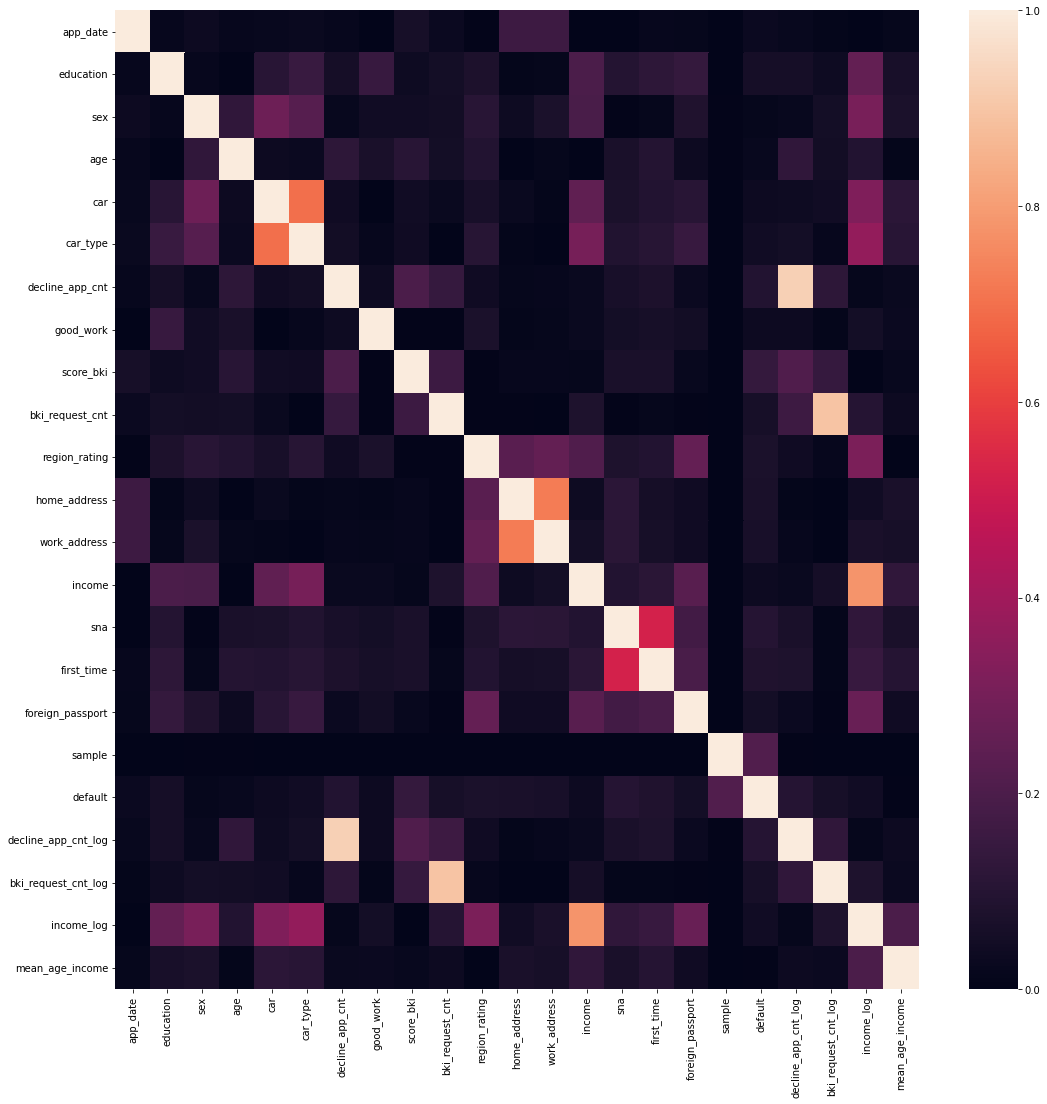

In [45]:
fig, axes = plt.subplots( figsize=(18, 18))

sns.heatmap(data.corr().abs(), vmin=0, vmax=1)

Если посмотреть на данную матрицу корреляций, то можно сделать вывод, что у нас достаточно малая взаимосвязь между признаками в целом, однако некоторые признаки стоит убрать

Начнем по порядку
1. Есть достаточно сильная связь между наличием машины и ей типом, стоит убрать тип машины, так как если машины нет, то автоматически ей присваивается нулевая категория, при чем связь типа машины немного сильнее по сравнению с наличием машины
2. decline_app_cnt_log так же стоит удалить, так как это нормализованный признак от decline_app_cnt, который мы сделали бинарным
3. bki_request_cnt имеет очень сильное смещение в право, но нормализация немного поправила положение, и распределение по boxplot идет более вменяемо, поэтому умеет смысл оставить только нормализованный признак, так как при желании можем получить данные обратно
4. Наблюдается сильная корреляция между категориями адреса жилья и адресом работы - скорее всего это связано с тем, что чем более лучшая категория работы - тем лучшую категорию жилья человек ожет себе позволить. Есть смысл оставить категорию рабочего адреса, так как более надежные компании могут себе позволить располокатьна на более качественных местах
5. Уровень зарплаты имеет смещение, поэтому следует оставить нормализировнную версию данного параметра
6. Есть взаимосвязь между наличием связей у заемщика с другими клиентами банка и когда заемщик впервые обратился в банк, скорее всего это из-за рекомендаций, на мой взгляд, можно оставить как есть, так как связь меньще 0.6

In [46]:
data.drop(['car_type','decline_app_cnt_log', 'bki_request_cnt', 'home_address', 'income'],axis = 1, inplace=True)

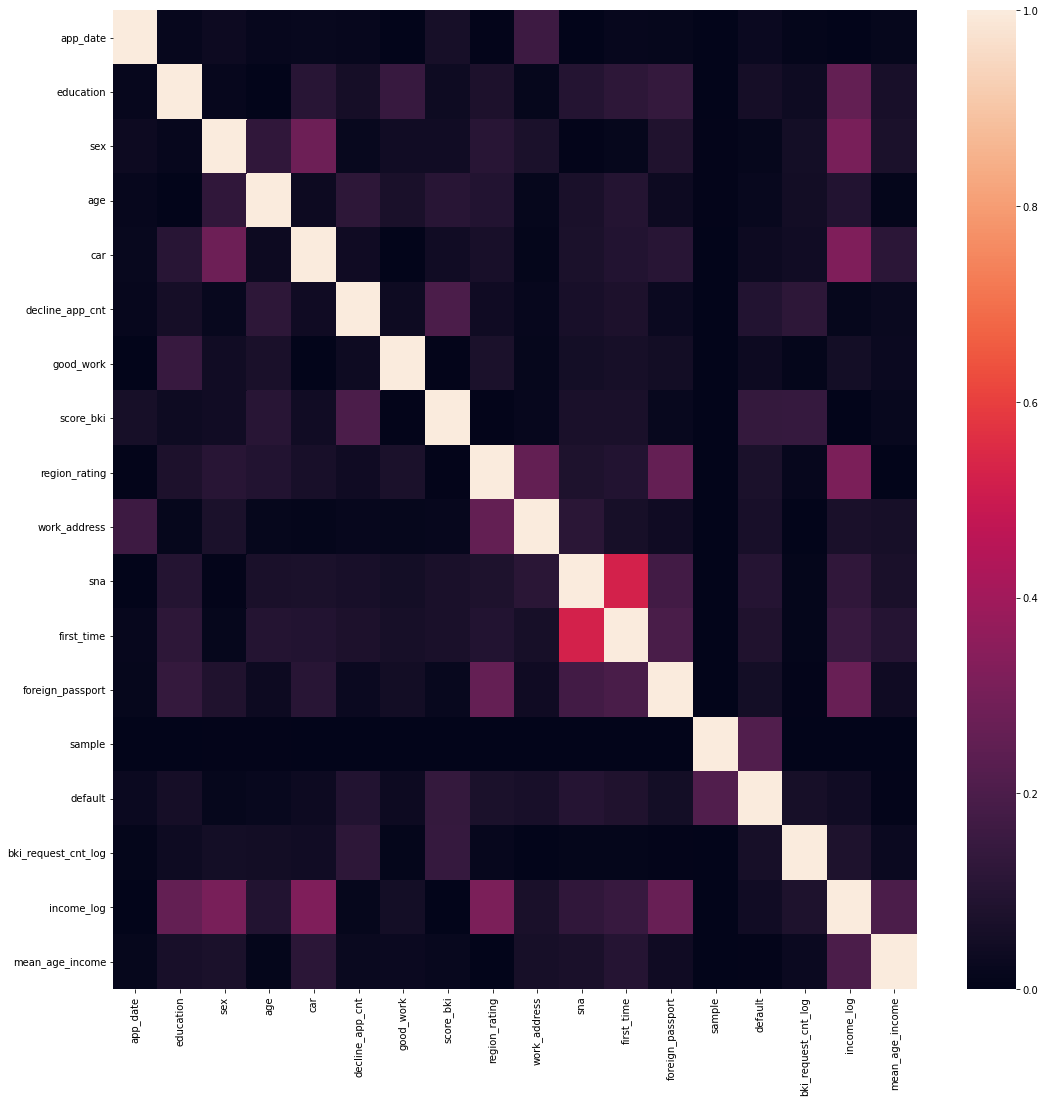

In [47]:
fig, axes = plt.subplots( figsize=(18, 18))

sns.heatmap(data.corr().abs(), vmin=0, vmax=1)

Обновим списки признаков

In [48]:
cat_cols = ['first_time', 'sna', 'work_address']
bin_cols = ['sex', 'car', 'good_work', 'foreign_passport', 'decline_app_cnt']
num_cols = ['age', 'score_bki', 'region_rating', 'bki_request_cnt_log', 'income_log', 'mean_age_income', 'app_date']

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   app_date             110148 non-null  int64  
 1   education            110148 non-null  int64  
 2   sex                  110148 non-null  int64  
 3   age                  110148 non-null  float64
 4   car                  110148 non-null  int64  
 5   decline_app_cnt      110148 non-null  int64  
 6   good_work            110148 non-null  int64  
 7   score_bki            110148 non-null  float64
 8   region_rating        110148 non-null  int64  
 9   work_address         110148 non-null  int64  
 10  sna                  110148 non-null  int64  
 11  first_time           110148 non-null  int64  
 12  foreign_passport     110148 non-null  int64  
 13  sample               110148 non-null  int64  
 14  default              110148 non-null  int64  
 15  bki_request_cnt_l

In [50]:
data

,app_date,education,sex,age,car,decline_app_cnt,good_work,score_bki,region_rating,work_address,sna,first_time,foreign_passport,sample,default,bki_request_cnt_log,income_log,mean_age_income
0,1395446400,1,1,3.401197,1,0,0,-2.271884,50,1,0,3,0,0,0,1.386294,10.819798,41395.856091
1,1390521600,3,0,3.688879,0,1,0,-1.504999,50,1,3,2,0,0,0,1.098612,8.517393,45984.161228
2,1395532800,4,1,3.931826,1,0,0,-1.691339,50,1,0,2,1,0,0,0.693147,10.308986,41288.659221
3,1391385600,3,1,4.043051,0,0,0,-2.374182,40,1,0,2,0,0,0,0.693147,9.741027,38007.592931
4,1391472000,1,0,3.663562,0,0,0,-2.487502,80,2,0,2,0,0,0,0.000000,11.695255,46022.711726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,1393891200,1,0,3.828641,0,0,0,-1.792064,50,1,3,3,0,1,0,1.386294,9.741027,46347.315884
110144,1395619200,3,1,3.737670,1,0,0,-2.058029,50,1,0,3,0,1,0,0.693147,11.156265,44509.743937
110145,1398124800,3,1,3.465736,0,0,0,-1.512635,80,2,1,1,0,1,0,1.609438,10.714440,43755.296033
110146,1388793600,3,0,3.401197,0,0,1,-1.479334,50,2,1,2,0,1,1,1.386294,9.472782,41395.856091


# Подготовка данных и обучение модели

In [51]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

In [52]:
train_data = pd.get_dummies(train_data, columns=['education'], )
test_data = pd.get_dummies(test_data, columns=['education'], )

In [53]:
train_data.columns

Index(['app_date', 'sex', 'age', 'car', 'decline_app_cnt', 'good_work',
       'score_bki', 'region_rating', 'work_address', 'sna', 'first_time',
       'foreign_passport', 'default', 'bki_request_cnt_log', 'income_log',
       'mean_age_income', 'education_0', 'education_1', 'education_2',
       'education_3', 'education_4'],
      dtype='object')

In [54]:
edu_cols = ['education_1', 'education_2', 'education_3', 'education_4']

In [55]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(train_data[num_cols].values)

In [56]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train_data[cat_cols].values)

In [57]:
X = np.hstack([X_num, train_data[bin_cols].values, X_cat, train_data[edu_cols].values])
y = train_data['default'].values  # наш таргет

In [58]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных


# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# проверяем
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 27), (14760, 27), (59039,), (14760,))

In [60]:
# Импортируем необходимые библиотеки:
from sklearn.linear_model import LogisticRegression # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [61]:
logreg = LogisticRegression( max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [62]:
y_pred_probs = logreg.predict_proba(X_test)[:, 1]

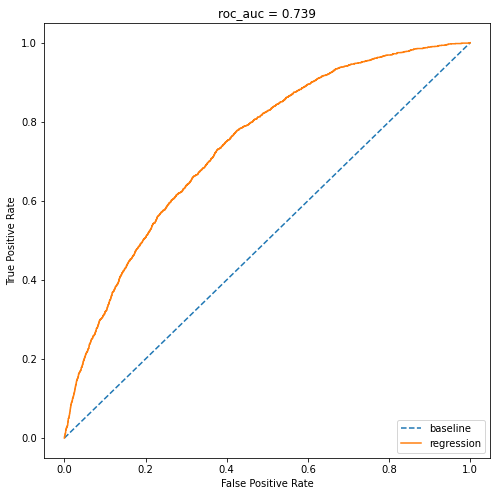

In [63]:
plt.rcParams["figure.figsize"] = 8, 8
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

plt.plot([0, 1], label="baseline", linestyle="--")
plt.plot(fpr, tpr, label="regression")
plt.title(f"roc_auc = {roc_auc:0.3f}")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right");



In [64]:
from sklearn.metrics import classification_report
classification_report = classification_report(y_test, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     12933
           1       0.42      0.02      0.04      1827

    accuracy                           0.88     14760
   macro avg       0.65      0.51      0.49     14760
weighted avg       0.82      0.88      0.82     14760



Получается, что алгоритм говорит, что 93% клинтам мможно выдавать кредит, что есть не хорошо.

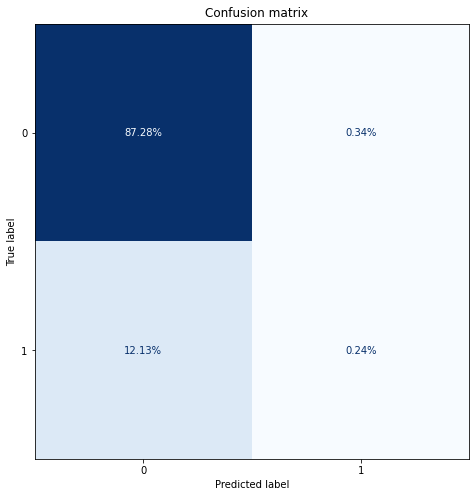

In [65]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm/np.sum(cm), display_labels=logreg.classes_) # или confusion_matrix=cm
disp.plot(cmap="Blues", colorbar=False, values_format=".2%") # или values_format=".0f"
plt.suptitle("Confusion matrix", x=.52, y=.91);

In [66]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)
f_score = (2 * precision * recall / (precision + recall))[:-1] 
best_f_score = max(f_score)
threshold = thresholds[np.argmax(f_score)]
print(f"threshold = {threshold}\nbest_f_score = {best_f_score}")

threshold = 0.16112144437695797
best_f_score = 0.3522120846961611


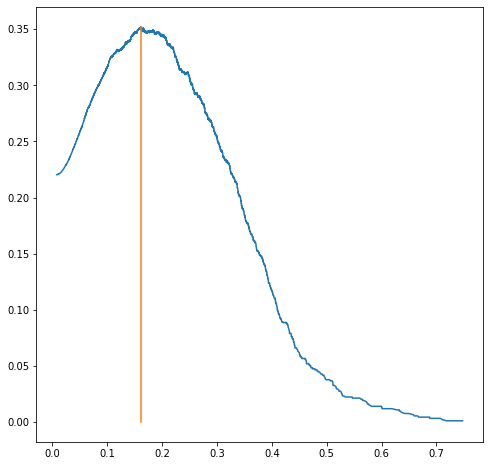

In [67]:
plt.plot(thresholds, f_score)
plt.plot(np.array([threshold] * 1000), np.linspace(0, best_f_score, 1000))

In [68]:
y_pred_probs[y_pred_probs >= threshold] = 1
y_pred_probs[y_pred_probs < threshold] = 0

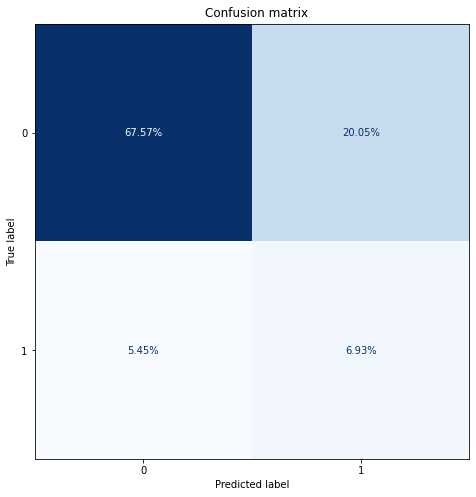

In [69]:
cm = confusion_matrix(y_test, y_pred_probs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm/np.sum(cm), display_labels=logreg.classes_) 
disp.plot(cmap="Blues", colorbar=False, values_format=".2%") 
plt.suptitle("Confusion matrix", x=.52, y=.91);

Таким образом мы изменили порог дефолта, теперь мы отсеиваем чать "хороших" клиентов, но теперь меньше ошибаемся в дефолтных клиентах. необходимо будет посмотреть, как это будет работать в итоге


# Гиперпараметры

In [70]:
iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

In [71]:
gridsearch = GridSearchCV(logreg, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
logreg = gridsearch.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 220.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1541, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 1150, in _fit_liblinear
    class_weight_ = compute_class_weight(class_weight, classes=classes_, y=y)
  File

In [72]:
best_parameters = logreg.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: None
	solver: 'sag'
	tol: 0.001
	verbose: 0
	warm_start: False


In [75]:
y_pred = logreg.predict(X_test)
y_pred_probs = logreg.predict_proba(X_test)[:, 1]
f1_score(y_pred, y_test)

0.33256973453712435

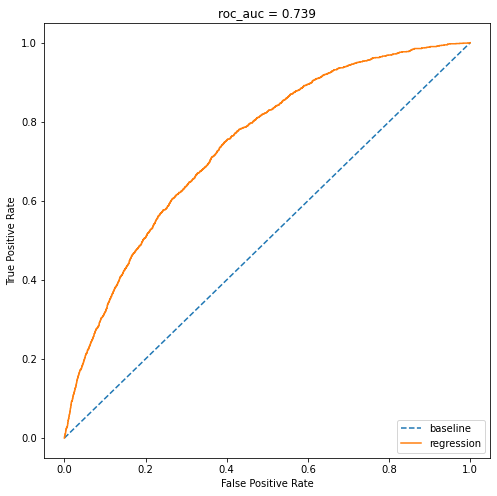

In [76]:
plt.rcParams["figure.figsize"] = 8, 8
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

plt.plot([0, 1], label="baseline", linestyle="--")
plt.plot(fpr, tpr, label="regression")
plt.title(f"roc_auc = {roc_auc:0.3f}")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right");



In [77]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)
f_score = (2 * precision * recall / (precision + recall))[:-1] 
best_f_score = max(f_score)
threshold = thresholds[np.argmax(f_score)]
print(f"threshold = {threshold}\nbest_f_score = {best_f_score}")

threshold = 0.5679018754546701
best_f_score = 0.3510875149854427


# Финальное предсказание

In [78]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(test_data[num_cols].values)

In [79]:
X_cat = OneHotEncoder(sparse = False).fit_transform(test_data[cat_cols].values)

In [80]:
X_test = np.hstack([X_num, test_data[bin_cols].values, X_cat, test_data[edu_cols].values])


In [81]:
y_pred = logreg.predict_proba(X_test)[:, 1]
y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0 

In [82]:
sample_submission['default'] = y_pred
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0.0
1,17527,1.0
2,75683,0.0
3,26883,0.0
4,28862,0.0
5,99881,1.0
6,26630,1.0
7,79934,0.0
8,16605,0.0
9,105449,0.0


In [83]:
sample_submission.describe()

,client_id,default
count,36349.000000,36349.000000
mean,54945.647473,0.275386
std,31706.052195,0.446715
min,4.000000,0.000000
25%,27744.000000,0.000000
50%,54657.000000,0.000000
75%,82322.000000,1.000000
max,110148.000000,1.000000


In [ ]:
!kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"
# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
